In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import time
import copy
import os

In [2]:
batch_size = 128
learning_rate = 1e-3

transforms = transforms.Compose(
[
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root='emotion5/train/', transform=transforms)
test_dataset = datasets.ImageFolder(root='emotion5/test/', transform=transforms)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
def imshow(inp, title=None):
    
    inp = inp.cpu() if device else inp
    inp = inp.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

images-size: torch.Size([128, 3, 48, 48])
out-size: torch.Size([3, 802, 402])


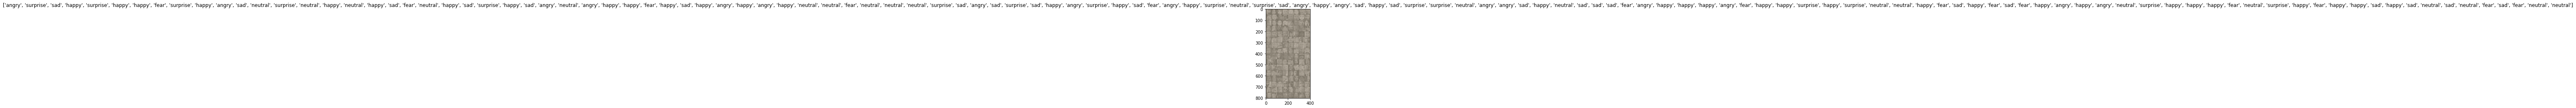

In [4]:
images, labels = next(iter(train_dataloader)) 
print("images-size:", images.shape)

out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)

imshow(out, title=[train_dataset.classes[x] for x in labels])

In [5]:
net = models.resnet18(pretrained=True)
net = net.cuda() if device else net
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 128)
net.fc = net.fc.cuda() if device else net.fc

In [7]:
n_epochs = 150
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'resnet.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1

Epoch [1/150], Step [0/221], Loss: 5.3524
Epoch [1/150], Step [20/221], Loss: 5.3972
Epoch [1/150], Step [40/221], Loss: 5.4166
Epoch [1/150], Step [60/221], Loss: 5.3135
Epoch [1/150], Step [80/221], Loss: 5.3236
Epoch [1/150], Step [100/221], Loss: 5.3496
Epoch [1/150], Step [120/221], Loss: 5.1955
Epoch [1/150], Step [140/221], Loss: 5.3288
Epoch [1/150], Step [160/221], Loss: 5.1608
Epoch [1/150], Step [180/221], Loss: 5.3118
Epoch [1/150], Step [200/221], Loss: 5.0515
Epoch [1/150], Step [220/221], Loss: 5.0597

train-loss: 5.2799, train-acc: 0.4421
validation loss: 5.1397, validation acc: 1.4009

Improvement-Detected, save-model
Epoch 2

Epoch [2/150], Step [0/221], Loss: 5.0730
Epoch [2/150], Step [20/221], Loss: 5.0560
Epoch [2/150], Step [40/221], Loss: 5.1733
Epoch [2/150], Step [60/221], Loss: 4.8822
Epoch [2/150], Step [80/221], Loss: 5.1332
Epoch [2/150], Step [100/221], Loss: 5.0417
Epoch [2/150], Step [120/221], Loss: 4.9989
Epoch [2/150], Step [140/221], Loss: 

Epoch [13/150], Step [140/221], Loss: 1.8179
Epoch [13/150], Step [160/221], Loss: 1.5963
Epoch [13/150], Step [180/221], Loss: 2.0534
Epoch [13/150], Step [200/221], Loss: 2.2153
Epoch [13/150], Step [220/221], Loss: 1.8205

train-loss: 3.0737, train-acc: 56.2339
validation loss: 3.0247, validation acc: 53.5871

Improvement-Detected, save-model
Epoch 14

Epoch [14/150], Step [0/221], Loss: 1.5831
Epoch [14/150], Step [20/221], Loss: 1.7470
Epoch [14/150], Step [40/221], Loss: 1.8656
Epoch [14/150], Step [60/221], Loss: 1.9089
Epoch [14/150], Step [80/221], Loss: 1.6676
Epoch [14/150], Step [100/221], Loss: 1.5896
Epoch [14/150], Step [120/221], Loss: 1.8596
Epoch [14/150], Step [140/221], Loss: 2.0764
Epoch [14/150], Step [160/221], Loss: 1.9943
Epoch [14/150], Step [180/221], Loss: 1.9339
Epoch [14/150], Step [200/221], Loss: 2.1292
Epoch [14/150], Step [220/221], Loss: 2.0431

train-loss: 2.9852, train-acc: 57.4011
validation loss: 2.9498, validation acc: 53.9550

Improvement-Detect

Epoch [26/150], Step [20/221], Loss: 1.4915
Epoch [26/150], Step [40/221], Loss: 1.3383
Epoch [26/150], Step [60/221], Loss: 1.2363
Epoch [26/150], Step [80/221], Loss: 1.0115
Epoch [26/150], Step [100/221], Loss: 1.2273
Epoch [26/150], Step [120/221], Loss: 1.3071
Epoch [26/150], Step [140/221], Loss: 1.1839
Epoch [26/150], Step [160/221], Loss: 0.9785
Epoch [26/150], Step [180/221], Loss: 1.4076
Epoch [26/150], Step [200/221], Loss: 1.5268
Epoch [26/150], Step [220/221], Loss: 1.3897

train-loss: 2.3081, train-acc: 66.9508
validation loss: 2.4306, validation acc: 57.2096

Improvement-Detected, save-model
Epoch 27

Epoch [27/150], Step [0/221], Loss: 1.3557
Epoch [27/150], Step [20/221], Loss: 1.4074
Epoch [27/150], Step [40/221], Loss: 1.4001
Epoch [27/150], Step [60/221], Loss: 1.3567
Epoch [27/150], Step [80/221], Loss: 1.3347
Epoch [27/150], Step [100/221], Loss: 1.3183
Epoch [27/150], Step [120/221], Loss: 1.2779
Epoch [27/150], Step [140/221], Loss: 1.6393
Epoch [27/150], Step [

Epoch [38/150], Step [220/221], Loss: 1.0305

train-loss: 1.9155, train-acc: 78.3999
validation loss: 2.2125, validation acc: 58.2001

Epoch 39

Epoch [39/150], Step [0/221], Loss: 0.7699
Epoch [39/150], Step [20/221], Loss: 0.8914
Epoch [39/150], Step [40/221], Loss: 0.7796
Epoch [39/150], Step [60/221], Loss: 0.7628
Epoch [39/150], Step [80/221], Loss: 0.7163
Epoch [39/150], Step [100/221], Loss: 0.6356
Epoch [39/150], Step [120/221], Loss: 0.6676
Epoch [39/150], Step [140/221], Loss: 0.7193
Epoch [39/150], Step [160/221], Loss: 1.0093
Epoch [39/150], Step [180/221], Loss: 0.7963
Epoch [39/150], Step [200/221], Loss: 0.8753
Epoch [39/150], Step [220/221], Loss: 0.9741

train-loss: 1.8877, train-acc: 79.5777
validation loss: 2.2013, validation acc: 58.3133

Epoch 40

Epoch [40/150], Step [0/221], Loss: 0.6253
Epoch [40/150], Step [20/221], Loss: 0.8031
Epoch [40/150], Step [40/221], Loss: 0.8883
Epoch [40/150], Step [60/221], Loss: 0.6733
Epoch [40/150], Step [80/221], Loss: 0.6590
Ep

Epoch [51/150], Step [200/221], Loss: 0.5532
Epoch [51/150], Step [220/221], Loss: 0.4506

train-loss: 1.5890, train-acc: 90.8676
validation loss: 2.1224, validation acc: 58.5963

Epoch 52

Epoch [52/150], Step [0/221], Loss: 0.2485
Epoch [52/150], Step [20/221], Loss: 0.4076
Epoch [52/150], Step [40/221], Loss: 0.4510
Epoch [52/150], Step [60/221], Loss: 0.4623
Epoch [52/150], Step [80/221], Loss: 0.4254
Epoch [52/150], Step [100/221], Loss: 0.3647
Epoch [52/150], Step [120/221], Loss: 0.3343
Epoch [52/150], Step [140/221], Loss: 0.3550
Epoch [52/150], Step [160/221], Loss: 0.4717
Epoch [52/150], Step [180/221], Loss: 0.3535
Epoch [52/150], Step [200/221], Loss: 0.3190
Epoch [52/150], Step [220/221], Loss: 0.3525

train-loss: 1.5665, train-acc: 91.5219
validation loss: 2.1203, validation acc: 58.4831

Epoch 53

Epoch [53/150], Step [0/221], Loss: 0.3980
Epoch [53/150], Step [20/221], Loss: 0.3738
Epoch [53/150], Step [40/221], Loss: 0.4041
Epoch [53/150], Step [60/221], Loss: 0.3992
E

Epoch [64/150], Step [180/221], Loss: 0.2301
Epoch [64/150], Step [200/221], Loss: 0.1498
Epoch [64/150], Step [220/221], Loss: 0.2129

train-loss: 1.3274, train-acc: 97.0148
validation loss: 2.1179, validation acc: 58.2708

Epoch 65

Epoch [65/150], Step [0/221], Loss: 0.1160
Epoch [65/150], Step [20/221], Loss: 0.3009
Epoch [65/150], Step [40/221], Loss: 0.1258
Epoch [65/150], Step [60/221], Loss: 0.2665
Epoch [65/150], Step [80/221], Loss: 0.2221
Epoch [65/150], Step [100/221], Loss: 0.1946
Epoch [65/150], Step [120/221], Loss: 0.1807
Epoch [65/150], Step [140/221], Loss: 0.1766
Epoch [65/150], Step [160/221], Loss: 0.2881
Epoch [65/150], Step [180/221], Loss: 0.1383
Epoch [65/150], Step [200/221], Loss: 0.1511
Epoch [65/150], Step [220/221], Loss: 0.2338

train-loss: 1.3100, train-acc: 97.2659
validation loss: 2.1195, validation acc: 57.8180

Epoch 66

Epoch [66/150], Step [0/221], Loss: 0.3464
Epoch [66/150], Step [20/221], Loss: 0.1568
Epoch [66/150], Step [40/221], Loss: 0.1404


Epoch [77/150], Step [160/221], Loss: 0.1065
Epoch [77/150], Step [180/221], Loss: 0.1728
Epoch [77/150], Step [200/221], Loss: 0.0568
Epoch [77/150], Step [220/221], Loss: 0.1121

train-loss: 1.1277, train-acc: 98.6807
validation loss: 2.1490, validation acc: 57.4218

Epoch 78

Epoch [78/150], Step [0/221], Loss: 0.0853
Epoch [78/150], Step [20/221], Loss: 0.1204
Epoch [78/150], Step [40/221], Loss: 0.0718
Epoch [78/150], Step [60/221], Loss: 0.1005
Epoch [78/150], Step [80/221], Loss: 0.1112
Epoch [78/150], Step [100/221], Loss: 0.0964
Epoch [78/150], Step [120/221], Loss: 0.1117
Epoch [78/150], Step [140/221], Loss: 0.0879
Epoch [78/150], Step [160/221], Loss: 0.1429
Epoch [78/150], Step [180/221], Loss: 0.0670
Epoch [78/150], Step [200/221], Loss: 0.1613
Epoch [78/150], Step [220/221], Loss: 0.0719

train-loss: 1.1145, train-acc: 98.7939
validation loss: 2.1521, validation acc: 57.4077

Epoch 79

Epoch [79/150], Step [0/221], Loss: 0.0695
Epoch [79/150], Step [20/221], Loss: 0.0894

Epoch [90/150], Step [140/221], Loss: 0.0598
Epoch [90/150], Step [160/221], Loss: 0.1246
Epoch [90/150], Step [180/221], Loss: 0.0740
Epoch [90/150], Step [200/221], Loss: 0.0407
Epoch [90/150], Step [220/221], Loss: 0.0501

train-loss: 0.9769, train-acc: 99.2643
validation loss: 2.1935, validation acc: 57.3794

Epoch 91

Epoch [91/150], Step [0/221], Loss: 0.0632
Epoch [91/150], Step [20/221], Loss: 0.0328
Epoch [91/150], Step [40/221], Loss: 0.0720
Epoch [91/150], Step [60/221], Loss: 0.0449
Epoch [91/150], Step [80/221], Loss: 0.0580
Epoch [91/150], Step [100/221], Loss: 0.0500
Epoch [91/150], Step [120/221], Loss: 0.0447
Epoch [91/150], Step [140/221], Loss: 0.1111
Epoch [91/150], Step [160/221], Loss: 0.0577
Epoch [91/150], Step [180/221], Loss: 0.0656
Epoch [91/150], Step [200/221], Loss: 0.0699
Epoch [91/150], Step [220/221], Loss: 0.0686

train-loss: 0.9668, train-acc: 99.2572
validation loss: 2.1971, validation acc: 57.4784

Epoch 92

Epoch [92/150], Step [0/221], Loss: 0.048

Epoch [103/150], Step [100/221], Loss: 0.0481
Epoch [103/150], Step [120/221], Loss: 0.0631
Epoch [103/150], Step [140/221], Loss: 0.0798
Epoch [103/150], Step [160/221], Loss: 0.0303
Epoch [103/150], Step [180/221], Loss: 0.0382
Epoch [103/150], Step [200/221], Loss: 0.0518
Epoch [103/150], Step [220/221], Loss: 0.0440

train-loss: 0.8607, train-acc: 99.4695
validation loss: 2.2391, validation acc: 57.4077

Epoch 104

Epoch [104/150], Step [0/221], Loss: 0.0347
Epoch [104/150], Step [20/221], Loss: 0.0376
Epoch [104/150], Step [40/221], Loss: 0.0263
Epoch [104/150], Step [60/221], Loss: 0.0229
Epoch [104/150], Step [80/221], Loss: 0.0490
Epoch [104/150], Step [100/221], Loss: 0.0343
Epoch [104/150], Step [120/221], Loss: 0.0417
Epoch [104/150], Step [140/221], Loss: 0.0931
Epoch [104/150], Step [160/221], Loss: 0.0458
Epoch [104/150], Step [180/221], Loss: 0.0527
Epoch [104/150], Step [200/221], Loss: 0.0574
Epoch [104/150], Step [220/221], Loss: 0.0406

train-loss: 0.8528, train-acc:

Epoch [116/150], Step [20/221], Loss: 0.0206
Epoch [116/150], Step [40/221], Loss: 0.0188
Epoch [116/150], Step [60/221], Loss: 0.0309
Epoch [116/150], Step [80/221], Loss: 0.0193
Epoch [116/150], Step [100/221], Loss: 0.0260
Epoch [116/150], Step [120/221], Loss: 0.0413
Epoch [116/150], Step [140/221], Loss: 0.0401
Epoch [116/150], Step [160/221], Loss: 0.0383
Epoch [116/150], Step [180/221], Loss: 0.0473
Epoch [116/150], Step [200/221], Loss: 0.0254
Epoch [116/150], Step [220/221], Loss: 0.0475

train-loss: 0.7688, train-acc: 99.6428
validation loss: 2.2826, validation acc: 57.5209

Epoch 117

Epoch [117/150], Step [0/221], Loss: 0.0505
Epoch [117/150], Step [20/221], Loss: 0.0318
Epoch [117/150], Step [40/221], Loss: 0.0180
Epoch [117/150], Step [60/221], Loss: 0.0251
Epoch [117/150], Step [80/221], Loss: 0.0211
Epoch [117/150], Step [100/221], Loss: 0.0367
Epoch [117/150], Step [120/221], Loss: 0.0230
Epoch [117/150], Step [140/221], Loss: 0.0308
Epoch [117/150], Step [160/221], Lo

Epoch [128/150], Step [220/221], Loss: 0.0210

train-loss: 0.6998, train-acc: 99.6180
validation loss: 2.3197, validation acc: 57.7756

Epoch 129

Epoch [129/150], Step [0/221], Loss: 0.0285
Epoch [129/150], Step [20/221], Loss: 0.0277
Epoch [129/150], Step [40/221], Loss: 0.0432
Epoch [129/150], Step [60/221], Loss: 0.0162
Epoch [129/150], Step [80/221], Loss: 0.0195
Epoch [129/150], Step [100/221], Loss: 0.0258
Epoch [129/150], Step [120/221], Loss: 0.0883
Epoch [129/150], Step [140/221], Loss: 0.0375
Epoch [129/150], Step [160/221], Loss: 0.0325
Epoch [129/150], Step [180/221], Loss: 0.0234
Epoch [129/150], Step [200/221], Loss: 0.0363
Epoch [129/150], Step [220/221], Loss: 0.0300

train-loss: 0.6946, train-acc: 99.6781
validation loss: 2.3227, validation acc: 57.4926

Epoch 130

Epoch [130/150], Step [0/221], Loss: 0.0415
Epoch [130/150], Step [20/221], Loss: 0.0631
Epoch [130/150], Step [40/221], Loss: 0.0165
Epoch [130/150], Step [60/221], Loss: 0.0262
Epoch [130/150], Step [80/2

Epoch [141/150], Step [140/221], Loss: 0.0154
Epoch [141/150], Step [160/221], Loss: 0.0227
Epoch [141/150], Step [180/221], Loss: 0.0114
Epoch [141/150], Step [200/221], Loss: 0.0109
Epoch [141/150], Step [220/221], Loss: 0.0136

train-loss: 0.6378, train-acc: 99.7064
validation loss: 2.3560, validation acc: 57.5067

Epoch 142

Epoch [142/150], Step [0/221], Loss: 0.0187
Epoch [142/150], Step [20/221], Loss: 0.0199
Epoch [142/150], Step [40/221], Loss: 0.0249
Epoch [142/150], Step [60/221], Loss: 0.0650
Epoch [142/150], Step [80/221], Loss: 0.0318
Epoch [142/150], Step [100/221], Loss: 0.0323
Epoch [142/150], Step [120/221], Loss: 0.0185
Epoch [142/150], Step [140/221], Loss: 0.0377
Epoch [142/150], Step [160/221], Loss: 0.0385
Epoch [142/150], Step [180/221], Loss: 0.0192
Epoch [142/150], Step [200/221], Loss: 0.0287
Epoch [142/150], Step [220/221], Loss: 0.0277

train-loss: 0.6335, train-acc: 99.7206
validation loss: 2.3587, validation acc: 57.6765

Epoch 143

Epoch [143/150], Step 

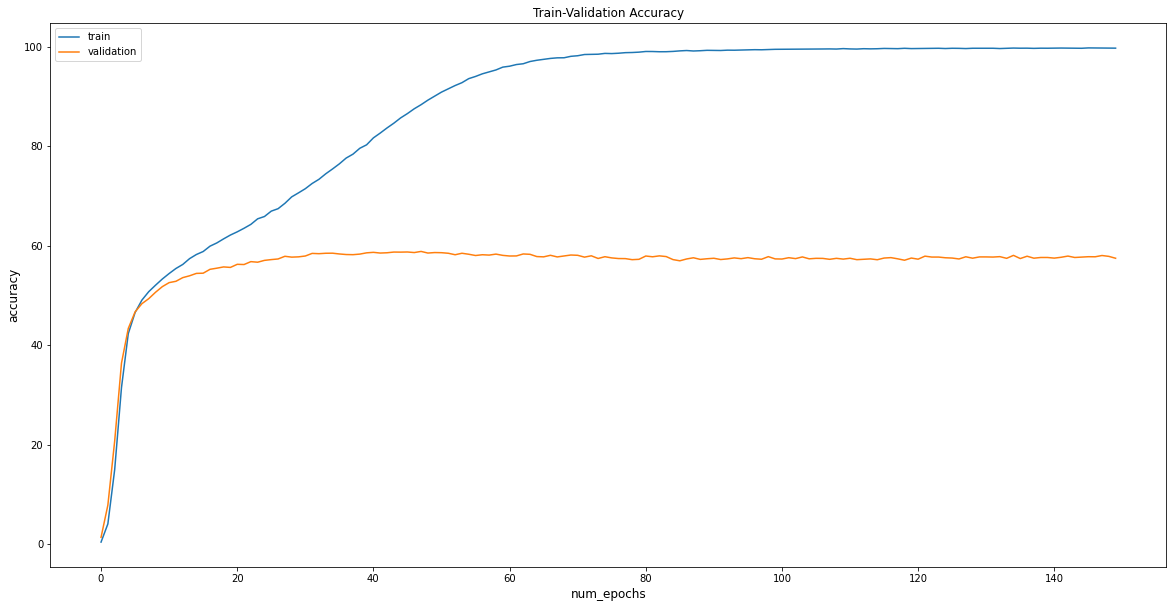

In [8]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

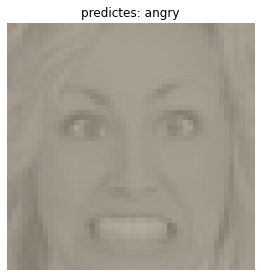

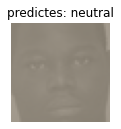

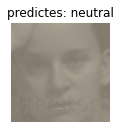

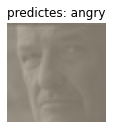

In [9]:
def visualize_model(net, num_images=4):
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        if device:
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy() if device else preds.numpy()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(2, num_images//2, images_so_far)
            ax.axis('off')
            ax.set_title('predictes: {}'.format(test_dataset.classes[preds[j]]))
            imshow(inputs[j])
            
            if images_so_far == num_images:
                return 

plt.ion()
visualize_model(net)
plt.ioff()